### Generic Imports

In [58]:
#import scipy.signal
print('Start')
from IPython.display import Audio, display
import numpy as np
import tqdm
import matplotlib.pyplot as plt
#from matplotlib import gridspec
import warnings
import random
import sklearn.preprocessing
import norbert
import musdb
import torch
import os
import pickle 

warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

from use_openunmix import SlakhDataset
import use_openunmix
import openunmix
import torch.nn as nn
import torch.optim as optim

from torch.optim.lr_scheduler import StepLR

import time

Start
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Initialize the dataset

In [5]:
%cd ../open-unmix-pytorch/
%pwd

/home/olaf/Documents/GitHub/ddspzart/ws_2/open-unmix-pytorch


'/home/olaf/Documents/GitHub/ddspzart/ws_2/open-unmix-pytorch'

torch.Size([1, 220500])
torch.Size([1, 1, 2049, 212])


/home/olaf/Documents/GitHub/ddspzart/ws_2/.openunmix_venv/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


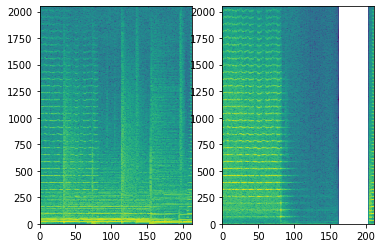

In [7]:
# Example input for model
stft = openunmix.transforms.TorchSTFT() # -> shape (nb_samples, nb_channels, nb_bins, nb_frames, complex=2)
spec = openunmix.transforms.ComplexNorm(mono=True) # -> shape (nb_samples, nb_channels(=1 if mono), nb_bins, nb_frames)
transform = nn.Sequential(stft, spec)

## Set up the model

In [1]:
SAVE_PATH = f"../source_seperation/data/checkpoints/"
CKPT_FILE = "exp4_trumpet_v3_with_valid_v2.pt"
DATASET_STAT_FILE = "exp4_dataset_statistics.pickle" 
%pwd

'/home/olaf/Documents/GitHub/ddspzart/ws_2/source_seperation'

In [3]:
import pickle
with open(SAVE_PATH+DATASET_STAT_FILE, 'rb') as targets_file:
    stat = pickle.load(targets_file)
    mean, scale = stat

In [23]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(42)

device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
# device = "cpu"

unmix = openunmix.model.OpenUnmix(
    input_mean=mean,
    input_scale=scale,
    nb_channels=1,
    hidden_size=512,
    max_bin=512,
    nb_bins=2048+1
).to(device)

optimizer = optim.RMSprop(unmix.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()


# Test a model 

In [ ]:
# Testing
test_dataset = SlakhDataset(split='test',seq_duration=5.0)
test_sampler = torch.utils.data.DataLoader(test_dataset, batch_size=8)
test_dataset.target = 'Trumpet'
test_dataset.filter_target()

In [19]:
# Load model
checkpoint = torch.load(SAVE_PATH+CKPT_FILE)
unmix.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [71]:
# Seperate with customly trained models
track = test_dataset[0]

print(track[0][None,...].shape)
audio_torch = track[0][None,...].float().to(device)
print(audio_torch)
target_models = {"Trumpet": unmix}
own_seperator = openunmix.model.Separator(target_models,nb_channels=1).to(device)
#y = torch.tensor(track[1][None,...]).float().to(device).clone().detach().squeeze()
y = track[1][None,...].float().to(device).squeeze()
print(y)
y_hat = own_seperator.forward(audio_torch).clone().detach().squeeze()
print(y_hat)
display(Audio(track[0], rate=44100))
display(Audio(y.cpu().numpy(), rate=44100))
display(Audio(y_hat.cpu().numpy(), rate=44100))

print(torch.mean((y-y_hat)**2))

get item 0.2800896990002002
torch.Size([1, 1, 220500])
tensor([[[ 0.0320,  0.0334,  0.0362,  ..., -0.0493, -0.0417, -0.0359]]])
tensor([-0.0483, -0.0481, -0.0458,  ..., -0.0016, -0.0004,  0.0012])
tensor([ 0.0013,  0.0012,  0.0012,  ..., -0.0038,  0.0002,  0.0024])


tensor(0.0009)


In [40]:


unmix.eval()
stft = openunmix.transforms.TorchSTFT() 
spec = openunmix.transforms.ComplexNorm(mono=True)
transform = nn.Sequential(stft, spec).to(device)
losses = openunmix.utils.AverageMeter()


In [41]:

for epoch in tqdm.notebook.tqdm(range(4)):
    for x, y in test_sampler:
        x, y = x.to(device), y.to(device)
        X = transform(x)
        Y = transform(y)
        Y_hat = unmix(X)
        loss = torch.nn.functional.mse_loss(Y_hat, Y)
        losses.update(loss.item(), Y.size(1))
    print(f"{losses.avg:.3f}")

  0%|          | 0/4 [00:00<?, ?it/s]

0.512
0.359
0.427
0.336


In [40]:
# Seperate with customly trained models
track = train_dataset[0]

print(track[0][None,...].shape)
audio_torch = track[0][None,...].float().to(device)
print(audio_torch)
target_models = {"French horn": unmix}
own_seperator = openunmix.model.Separator(target_models,nb_channels=1).to(device)
#y = torch.tensor(track[1][None,...]).float().to(device).clone().detach().squeeze()
y = track[1][None,...].float().to(device).squeeze()
print(y)
y_hat = own_seperator.forward(audio_torch).clone().detach().squeeze()
print(y_hat)
display(Audio(track[0], rate=44100))
display(Audio(y.cpu().numpy(), rate=44100))
display(Audio(y_hat.cpu().numpy(), rate=44100))

print(torch.mean((y-y_hat)**2))

torch.Size([1, 1, 220500])
tensor([[[0.0168, 0.0291, 0.0341,  ..., 0.3149, 0.3135, 0.3051]]],
       device='cuda:0')
tensor([0.0658, 0.0687, 0.0629,  ..., 0.0150, 0.0175, 0.0188], device='cuda:0')
tensor([-0.0173, -0.0122, -0.0057,  ...,  0.0056,  0.0069,  0.0072],
       device='cuda:0')


tensor(0.0017, device='cuda:0')


In [41]:
# Evaluation
import museval

global_rate = 44_100
win = 1.0; hop = 1.0; mode='v4'
y_np = y.cpu().numpy()
y_hat_np = y_hat.cpu().numpy()
reference = np.reshape(y_np,(1,len(y),1))
estimates = np.reshape(y_hat_np,(1,len(y),1))

print(reference.shape,estimates.shape)

metrics = museval.evaluate(reference,estimates, 
                        win=int(win*global_rate),hop=int(hop*global_rate),mode=mode)

metrics = [np.mean(m) for m in metrics]
print(metrics)
SDR, ISR, SIR, SAR = metrics


(1, 220500, 1) (1, 220500, 1)
[-0.30052876664668793, 2.9240673314491366, inf, -6.198049423589732]


## Synthesize



In [56]:
import musdb
mus = musdb.DB(download=True, subsets='test')
track = mus[1]
print(track.audio.T[None, ...].shape)

(300032, 2)

In [40]:

track = train_dataset[0]
print(track[0][None,...].shape)

torch.Size([1, 1, 220500])


In [ ]:
# Example input for model
stft = openunmix.transforms.TorchSTFT() # -> shape (nb_samples, nb_channels, nb_bins, nb_frames, complex=2)
spec = openunmix.transforms.ComplexNorm(mono=True) # -> shape (nb_samples, nb_channels(=1 if mono), nb_bins, nb_frames)
transform = nn.Sequential(stft, spec)

x, y = train_dataset[0]
print(x.shape)

# transform the time domain input to spectrograms
X = transform(x[None])
Y = transform(y[None])
print(X.shape)

f, axes = plt.subplots(1, 2)
axes[0].pcolormesh(np.log(X[0, 0, :, :].detach().numpy() ))
axes[1].pcolormesh(np.log(Y[0, 0, :, :].detach().numpy() ))

display(Audio(x, rate=44100))
display(Audio(y, rate=44100))
